# Feature Engineering and Pre-Processing

## Setup - Load Libraries and Data

In [89]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder

%matplotlib inline 

In [35]:
# Load data
ames_clean = pd.read_csv('data/Ames_Housing_Price_Data_clean.csv')

In [36]:
# Check data
print(ames_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579 entries, 0 to 2578
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   GrLivArea      2579 non-null   int64  
 1   SalePrice      2579 non-null   int64  
 2   MSSubClass     2579 non-null   int64  
 3   MSZoning       2579 non-null   object 
 4   LotFrontage    2579 non-null   float64
 5   LotArea        2579 non-null   int64  
 6   Street         2579 non-null   object 
 7   Alley          2579 non-null   object 
 8   LotShape       2579 non-null   object 
 9   LandContour    2579 non-null   object 
 10  Utilities      2579 non-null   object 
 11  LotConfig      2579 non-null   object 
 12  LandSlope      2579 non-null   object 
 13  Neighborhood   2579 non-null   object 
 14  Condition1     2579 non-null   object 
 15  Condition2     2579 non-null   object 
 16  BldgType       2579 non-null   object 
 17  HouseStyle     2579 non-null   object 
 18  OverallQ

In [37]:
# Initiate linear regression model
lr = LinearRegression()

---

## Feature Engineering

In [38]:
# Create new dataframe to add engineered features
ames_eng1 = ames_clean.copy()

#### YearsSinceBuilt

In [39]:
# Create a new feature representing YearsSinceBuilt and add to dataframe
YearsSinceBuilt = max(ames_eng1['YearBuilt']) - ames_eng1['YearBuilt']
ames_eng1['YearsSinceBuilt'] = YearsSinceBuilt

# Drop 'YearBuilt' column
ames_eng1 = ames_eng1.drop('YearBuilt', axis=1)

#### YearsSinceRemod

In [40]:
# Create a new feature representing YearsSinceRemod and add to dataframe
YearsSinceRemod = max(ames_eng1['YearRemodAdd']) - ames_eng1['YearRemodAdd']
ames_eng1['YearsSinceRemod'] = YearsSinceRemod

# Drop 'YearRemodAdd' column
ames_eng1 = ames_eng1.drop('YearRemodAdd', axis=1)

#### Economic Proxy Features

Since all the house sales happened in Ames, we might think that we have effectively controlled for these variables.  HOWEVER there is an important caveat: during the timeframe of the dataset (2006-2010), the US experienced the worst housing crisis in the post-Depression era.

We will engineer a simple feature 'Crisis':
- If the date of sale is prior to 1 June 2007, crisis = 0
- If the date of sale is after this date, crisis = 1

The cut-off date was picked somewhat arbitrarily, but is rooted in the collapse of two of Bear Stearns' mortgage debt hedge funds in the month of June 2007 (see: https://www.wsj.com/articles/SB118230204193441422).  In retrospect, risks had been building in the housing market for some time before then, but the collapse of these funds is seen as a key event (see: https://www.cfr.org/timeline/us-financial-crisis).  The Case-Shiller National Home Price Index (see https://fred.stlouisfed.org/series/CSUSHPINSA) also seems to roughly confirm this timeline.

In [41]:
# Combine YrSold and MoSold into a new series
series_date_sold = pd.to_datetime(ames_eng1.YrSold.astype(str) + '-' + ames_eng1.MoSold.astype(str))

# Set the cutoff date
crisis_date = pd.to_datetime('2007-07')

# Create the 'Crisis' feature
after_crisis = (series_date_sold > crisis_date).astype(int)
ames_eng1['Crisis'] = after_crisis

In [42]:
# Check the 'Crisis' feature
print(ames_eng1['Crisis'].value_counts())

1    1648
0     931
Name: Crisis, dtype: int64


<AxesSubplot:xlabel='Crisis', ylabel='SalePrice'>

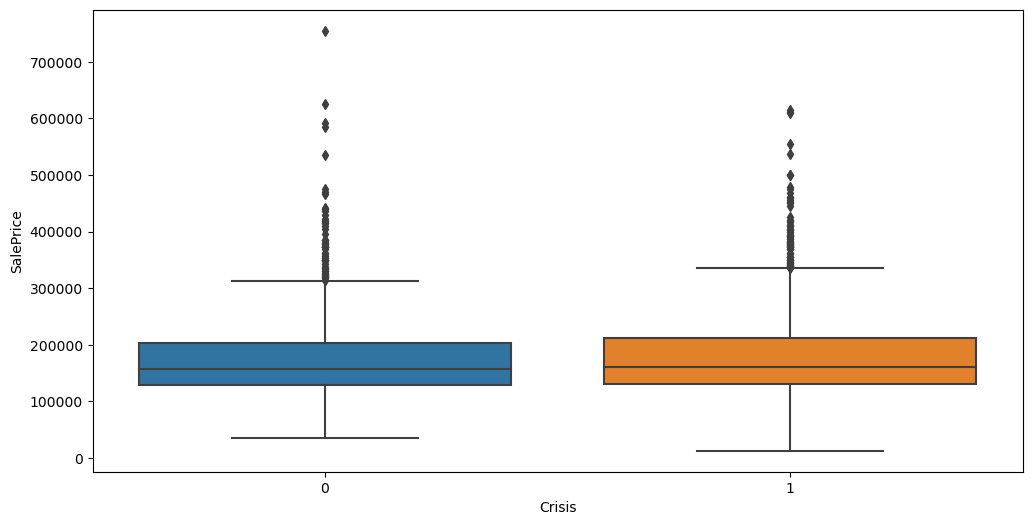

In [43]:
# Boxplot of SalePrice vs. crisis
plt.figure(figsize=(12, 6))
sns.boxplot(x='Crisis', y='SalePrice', data=ames_eng1)

In [44]:
# Fit the model
lr.fit(ames_eng1[['Crisis']], ames_eng1['SalePrice'])

# Print the R^2 score
lr.score(ames_eng1[['Crisis']], ames_eng1['SalePrice'])

0.0002456458842525766

Our 'crisis' variable doesn't provide very much explanatory value.  Let's take a look at how pricing changes as a function of time e.g. stationarity.

In [45]:
# Combine MoSold and YrSold into a single 'Date' column
macro = pd.DataFrame()
macro['DateSold'] = pd.to_datetime(ames_eng1['YrSold'].astype(str) + '-' + ames_eng1['MoSold'].astype(str) + '-01')

# Create a quarterly 'Period' column reflecting the date
macro['Period'] = pd.PeriodIndex(macro.DateSold, freq='Q')

# Concatenate macro and target
macro = pd.concat([macro, ames_eng1['SalePrice']], axis=1)

# Check the output
print(macro.head())

    DateSold  Period  SalePrice
0 2010-03-01  2010Q1     126000
1 2009-02-01  2009Q1     139500
2 2007-11-01  2007Q4     124900
3 2009-05-01  2009Q2     114000
4 2009-11-01  2009Q4     227000


In [46]:
# Group by 'Period' and calculate the median 'SalePrice'
median_prices = macro.groupby('Period')['SalePrice'].median().reset_index()

# Create a custom sorting function
def custom_sort(period):
    year, quarter = period.split('Q')
    return int(quarter), int(year)

# Sort periods using the custom sorting function
median_prices['Period'] = pd.PeriodIndex(median_prices['Period'], freq='Q')
median_prices['sort_key'] = median_prices['Period'].astype(str).apply(custom_sort)
median_prices = median_prices.sort_values('sort_key').drop('sort_key', axis=1)

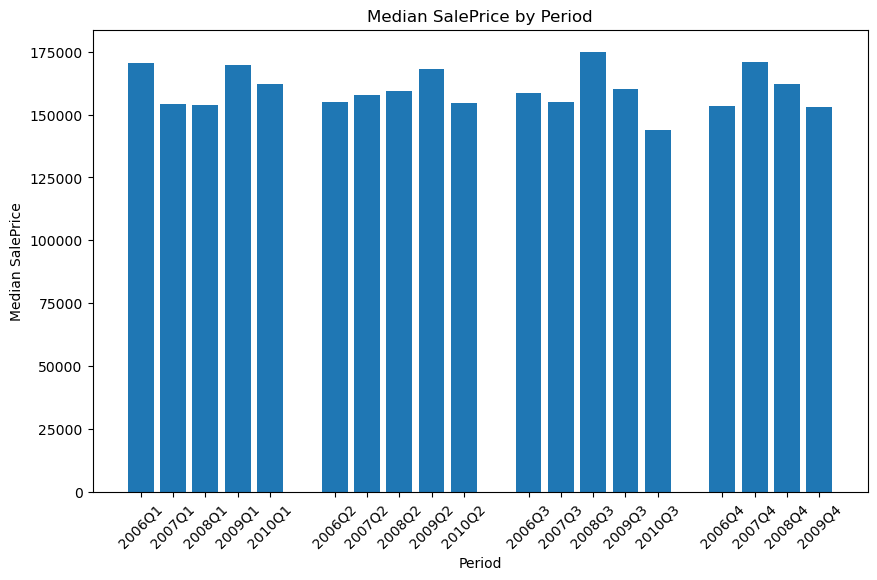

In [47]:
# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the new x-axis values with spaces between quarters
x_values = []
for i, period in enumerate(median_prices['Period']):
    x_val = i + i // 5
    x_values.append(x_val)

# Plot the bars with the new x-axis values
ax.bar(x_values, median_prices['SalePrice'])

# Label the plot
ax.set_title('Median SalePrice by Period')
ax.set_xlabel('Period')
ax.set_ylabel('Median SalePrice')

# Set the x-axis labels with the new x-axis values
ax.set_xticks(x_values)
ax.set_xticklabels(median_prices['Period'], rotation=45)

# Show the plot
plt.show()

#### Basement Features

In [48]:
# Create new basement features
# ames_eng1['TotalFinSF1pct'] = ames_eng1['BsmtFinSF1'] / ames_eng1['TotalBsmtSF']

---

## Categorize Columns for Encoding

In [49]:
# Check data
print(ames_eng1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579 entries, 0 to 2578
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   GrLivArea        2579 non-null   int64  
 1   SalePrice        2579 non-null   int64  
 2   MSSubClass       2579 non-null   int64  
 3   MSZoning         2579 non-null   object 
 4   LotFrontage      2579 non-null   float64
 5   LotArea          2579 non-null   int64  
 6   Street           2579 non-null   object 
 7   Alley            2579 non-null   object 
 8   LotShape         2579 non-null   object 
 9   LandContour      2579 non-null   object 
 10  Utilities        2579 non-null   object 
 11  LotConfig        2579 non-null   object 
 12  LandSlope        2579 non-null   object 
 13  Neighborhood     2579 non-null   object 
 14  Condition1       2579 non-null   object 
 15  Condition2       2579 non-null   object 
 16  BldgType         2579 non-null   object 
 17  HouseStyle    

In [50]:
# Create a list of numeric features
numeric_features = ['GrLivArea',                # Above grade (ground) living area square feet
                    'LotFrontage',              # Linear feet of street connected to property
                    'LotArea',                  # Lot size in square feet
                    'MasVnrArea',               # Masonry veneer area in square feet
                    'BsmtFinSF1',               # Type 1 finished square feet
                    'BsmtFinSF2',               # Type 2 finished square feet
                    'BsmtUnfSF',                # Unfinished square feet of basement area
                    'TotalBsmtSF',              # Total square feet of basement area
                    '1stFlrSF',                 # First Floor square feet
                    '2ndFlrSF',                 # Second floor square feet
                    'LowQualFinSF',             # Low quality finished square feet (all floors)
                    'GarageArea',               # Size of garage in square feet
                    'WoodDeckSF',               # Wood deck area in square feet
                    'OpenPorchSF',              # Open porch area in square feet
                    'EnclosedPorch',            # Enclosed porch area in square feet
                    '3SsnPorch',                # Three season porch area in square feet
                    'ScreenPorch',              # Screen porch area in square feet
                    'PoolArea',                 # Pool area in square feet
                    'MiscVal'                   # $Value of miscellaneous feature
                    ]

In [54]:
# Create a list of ordinal categorical features
ordinal_features = ['OverallQual',              # Rates the overall material and finish of the house (1 is very poor, 10 is very excellent)
                    'OverallCond',              # Rates the overall condition of the house (1 is very poor, 10 is very excellent)
                    'BsmtFullBath',             # Basement full bathrooms
                    'BsmtHalfBath',             # Basement half bathrooms
                    'FullBath',                 # Full bathrooms above grade
                    'HalfBath',                 # Half baths above grade
                    'BedroomAbvGr',             # Bedrooms above grade (does NOT include basement bedrooms)
                    'KitchenAbvGr',             # Kitchens above grade
                    'TotRmsAbvGrd',             # Total rooms above grade (does not include bathrooms)
                    'Fireplaces',               # Number of fireplaces
                    'GarageYrBlt',              # Year garage was built
                    'GarageCars',               # Size of garage in car capacity
                    'MoSold',                   # Month Sold (MM)
                    'YrSold',                   # Year Sold (YYYY)
                    'YearsSinceBuilt',          # Latest date - original construction date
                    'YearsSinceRemod',          # Latest date - remodel date (same as construction date if no remodeling or additions)
                    'Crisis'                    # 1 if after July 2007, 0 otherwise
                    ]


In [55]:
# Create a list of nominative categorical features

nominative_features = ['MSSubClass',            # 20, 30, 40, 45... <- UNCLEAR IF ORDER CONTAINS INFORMATION
                       'MSZoning',              # A, C, FV, I, RH, RL, RP, RM
                       'Street',                # Grvl, Pave
                       'Alley',                 # Grvl, Pave, NA 
                       'LotShape',              # Reg, IR1, IR2, IR3
                       'LandContour',           # Lvl, Bnk, HLS, Low 
                       'Utilities',             # AllPub, NoSewr, NoSeWa, ELO
                       'LotConfig',             # Inside, Corner, CulDSac, FR2, FR3
                       'LandSlope',             # Gtl, Mod, Sev
                       'Neighborhood',          # Blmngtn, Blueste, BrDale, BrkSide, ClearCr, CollgCr...
                       'Condition1',            # Artery, Feedr, Norm, RRNn, RRAn, PosN, PosA, RRNe, RRAe
                       'Condition2',            # Artery, Feedr, Norm, RRNn, RRAn, PosN, PosA, RRNe, RRAe
                       'BldgType',              # 1Fam, 2FmCon, Duplx, TwnhsE, TwnhsI
                       'HouseStyle',            # 1Story, 1.5Fin, 1.5Unf, 2Story, 2.5Fin, 2.5Unf, SFoyer, SLvl
                       'RoofStyle',             # Flat, Gable, Gambrel, Hip, Mansard, Shed
                       'RoofMatl',              # ClyTile, CompShg, Membran, Metal, Roll, Tar&Grv, WdShake, WdShngl
                       'Exterior1st',           # AsbShng, AsphShn, BrkComm, BrkFace, CBlock, CemntBd...
                       'Exterior2nd',           # AsbShng, AsphShn, BrkComm, BrkFace, CBlock, CemntBd...
                       'MasVnrType',            # BrkCmn, BrkFace, CBlock, None, Stone
                       'ExterQual',             # Ex, Gd, TA, Fa, Po (Ex is best and Po is worst) <- POTENTIAL LABEL ENCODING
                       'ExterCond',             # Ex, Gd, TA, Fa, Po (Ex is best and Po is worst) <- POTENTIAL LABEL ENCODING  
                       'Foundation',            # BrkTil, CBlock, PConc, Slab, Stone, Wood
                       'BsmtQual',              # Ex, Gd, TA, Fa, Po, NA (Ex is best and Po is worst) <- POTENTIAL LABEL ENCODING
                       'BsmtCond',              # Ex, Gd, TA, Fa, Po, NA (Ex is best and Po is worst) <- POTENTIAL LABEL ENCODING
                       'BsmtExposure',          # Gd, Av, Mn, No, NA (Gd is best and No is worst) <- POTENTIAL LABEL ENCODING
                       'BsmtFinType1',          # GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA (GLQ is best and Unf is worst) <- POTENTIAL LABEL ENCODING
                       'BsmtFinType2',          # GLQ, ALQ, BLQ, Rec, LwQ, Unf, NA (GLQ is best and Unf is worst) <- POTENTIAL LABEL ENCODING
                       'Heating',               # Floor, GasA, GasW, Grav, OthW, Wall
                       'HeatingQC',             # Ex, Gd, TA, Fa, Po (Ex is best and Po is worst) <- POTENTIAL LABEL ENCODING 
                       'CentralAir',            # N, Y
                       'Electrical',            # SBrkr, FuseA, FuseF, FuseP, Mix
                       'KitchenQual',           # Ex, Gd, TA, Fa, Po (Ex is best and Po is worst) <- POTENTIAL LABEL ENCODING
                       'Functional',            # Typ, Min1, Min2, Mod, Maj1, Maj2, Sev, Sal (Typ is best and Sal is worst) <- POTENTIAL LABEL ENCODING
                       'FireplaceQu',           # Ex, Gd, TA, Fa, Po, NA (Ex is best and Po is worst) <- POTENTIAL LABEL ENCODING
                       'GarageType',            # 2Types, Attchd, Basment, BuiltIn, CarPort, Detchd, NA
                       'GarageFinish',          # Fin, RFn, Unf, NA
                       'GarageQual',            # Ex, Gd, TA, Fa, Po, NA (Ex is best and Po is worst) <- POTENTIAL LABEL ENCODING
                       'GarageCond',            # Ex, Gd, TA, Fa, Po, NA (Ex is best and Po is worst) <- POTENTIAL LABEL ENCODING
                       'PavedDrive',            # Y, P, N
                       'PoolQC',                # Ex, Gd, TA, Fa, NA (Ex is best and Po is worst) <- POTENTIAL LABEL ENCODING
                       'Fence',                 # GdPrv, MnPrv, GdWo, MnWw, NA
                       'MiscFeature',           # Elev, Gar2, Othr, Shed, TenC, NA
                       'SaleType',              # WD, CWD, VWD, New, COD, Con, ConLw, ConLI, ConLD, Oth
                       'SaleCondition'          # Normal, Abnorml, AdjLand, Alloca, Family, Partial
                       ]    

In [56]:
# Combine lists of features into one list
all_features = numeric_features + ordinal_features + nominative_features

# Get list of columns from anes_eng1 dataframe
ames_eng1_columns = ames_eng1.columns

# Convert both lists to sets
all_features_set = set(all_features)
ames_eng1_columns_set = set(ames_eng1_columns)

# Find the difference between the two sets
missing_features = ames_eng1_columns_set  - all_features_set
print(missing_features)

{'SalePrice'}


----

## Multiple Linear Regression Preprocessing

In [62]:
# Create a new dataframe to hold MLR-specific data
ames_MLR = ames_eng1.copy()

In [63]:
# One hot encode ALL nominative features b/c columns that could potentially be label encoded are not linearly distributed
one_hot_encoded_columns = nominative_features

In [64]:
# One-hot encode features
one_hot_features = pd.get_dummies(ames_MLR[one_hot_encoded_columns], drop_first=True)

# Concatenate encoded features with original dataframe
ames_MLR = pd.concat([ames_MLR, one_hot_features], axis=1)

# Drop the original nominal_features columns
ames_MLR = ames_MLR.drop(nominative_features, axis=1)              

In [68]:
# Check encoded dataframe to ensure no more categorical values
print(ames_MLR.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579 entries, 0 to 2578
Columns: 269 entries, GrLivArea to SaleCondition_Partial
dtypes: float64(11), int64(26), uint8(232)
memory usage: 1.3 MB
None


In [67]:
# Save dataframe to csv
ames_MLR.to_csv('data/Ames_MLR.csv', index=False)

## Lasso Preprocessing

In [77]:
# Create a new dataframe to hold Lasso-specific data
ames_Lasso = ames_MLR.copy() # keep one-hot encoded features

In [78]:
# Check ames_Lasso
print(ames_Lasso.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579 entries, 0 to 2578
Columns: 269 entries, GrLivArea to SaleCondition_Partial
dtypes: float64(11), int64(26), uint8(232)
memory usage: 1.3 MB
None


In [79]:
# Scale the Data

# Drop the target
target = ames_Lasso['SalePrice']
lasso_features = ames_Lasso.drop('SalePrice', axis=1)

# Scale the features
scaler = StandardScaler()
lasso_features_scaled = scaler.fit_transform(lasso_features)

# Convert the scaled features back into a dataframe
ames_Lasso = pd.DataFrame(lasso_features_scaled, columns=lasso_features.columns)

# Add the target back in
ames_Lasso = pd.concat([ames_Lasso, target], axis=1)

In [80]:
# Check ames_Lasso
print(ames_Lasso.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579 entries, 0 to 2578
Columns: 269 entries, GrLivArea to SalePrice
dtypes: float64(268), int64(1)
memory usage: 5.3 MB
None


In [81]:
# Save dataframe to csv
ames_Lasso.to_csv('data/Ames_Lasso.csv', index=False)

## Random Forest Preprocessing

In [117]:
# Create a new dataframe to hold Random Forest-specific data
ames_RF = ames_eng1.copy() # discard one-hot encoded features

In [118]:
# Check ames_RF
print(ames_RF.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579 entries, 0 to 2578
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   GrLivArea        2579 non-null   int64  
 1   SalePrice        2579 non-null   int64  
 2   MSSubClass       2579 non-null   int64  
 3   MSZoning         2579 non-null   object 
 4   LotFrontage      2579 non-null   float64
 5   LotArea          2579 non-null   int64  
 6   Street           2579 non-null   object 
 7   Alley            2579 non-null   object 
 8   LotShape         2579 non-null   object 
 9   LandContour      2579 non-null   object 
 10  Utilities        2579 non-null   object 
 11  LotConfig        2579 non-null   object 
 12  LandSlope        2579 non-null   object 
 13  Neighborhood     2579 non-null   object 
 14  Condition1       2579 non-null   object 
 15  Condition2       2579 non-null   object 
 16  BldgType         2579 non-null   object 
 17  HouseStyle    

In [119]:
# Label encode all ordinal features
label_encoded_columns = ordinal_features

# Label encode features
label_encoder = LabelEncoder()
ames_RF[label_encoded_columns] = ames_RF[label_encoded_columns].apply(label_encoder.fit_transform)


In [120]:
# Check dataframe
print(ames_RF.head())

   GrLivArea  SalePrice  MSSubClass MSZoning  LotFrontage  LotArea Street  \
0        856     126000          30       RL          0.0     7890   Pave   
1       1049     139500         120       RL         42.0     4235   Pave   
2       1001     124900          30  C (all)         60.0     6060   Pave   
3       1039     114000          70       RL         80.0     8146   Pave   
4       1665     227000          60       RL         70.0     8400   Pave   

  Alley LotShape LandContour  ... Fence MiscFeature MiscVal MoSold YrSold  \
0  None      Reg         Lvl  ...  None        None       0      2      4   
1  None      Reg         Lvl  ...  None        None       0      1      3   
2  None      Reg         Lvl  ...  None        None       0     10      1   
3  None      Reg         Lvl  ...  None        None       0      4      3   
4  None      Reg         Lvl  ...  None        None       0     10      3   

  SaleType SaleCondition YearsSinceBuilt  YearsSinceRemod  Crisis  
0     

In [121]:
# Convert ExterQual and ExterCond to ordinal values
conversion_cols = ['ExterQual', 'ExterCond']

# Define a mapping from categories to integers
rating_mapping = {
    'Ex': 5,
    'Gd': 4,
    'TA': 3,
    'Fa': 2,
    'Po': 1
}

# Print unique values of each column before conversion
for col in conversion_cols:
    print(f"Column: {col}")
    print(ames_RF[col].unique())

# Apply the mapping to each column and remove from nominative_features
for col in conversion_cols:
    ames_RF[col] = ames_RF[col].map(rating_mapping)
    nominative_features.remove(col)

# Print unique values of each column after conversion
for col in conversion_cols:
    print(f"Column: {col}")
    print(ames_RF[col].unique())


Column: ExterQual
['TA' 'Gd' 'Fa' 'Ex']
Column: ExterCond
['TA' 'Gd' 'Fa' 'Ex' 'Po']
Column: ExterQual
[3 4 2 5]
Column: ExterCond
[3 4 2 5 1]


In [126]:
# Print remaining nominative features
print(ames_RF[nominative_features].columns)

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
       'SaleCondition'],
      dtype='object')


In [127]:
# One hot encode remaining nominative features
one_hot_encoded_columns = nominative_features

# One-hot encode features
one_hot_features = pd.get_dummies(ames_RF[one_hot_encoded_columns], drop_first=True)

# Concatenate encoded features with original dataframe
ames_RF = pd.concat([ames_RF, one_hot_features], axis=1)

# Drop the original nominal_features columns
ames_RF = ames_RF.drop(nominative_features, axis=1)      

In [128]:
# Check dataframe
print(ames_RF.head())
print(ames_RF.info())   

   GrLivArea  SalePrice  LotFrontage  LotArea  OverallQual  OverallCond  \
0        856     126000          0.0     7890            5            5   
1       1049     139500         42.0     4235            4            4   
2       1001     124900         60.0     6060            4            8   
3       1039     114000         80.0     8146            3            7   
4       1665     227000         70.0     8400            7            5   

   MasVnrArea  ExterQual  ExterCond  BsmtFinSF1  ...  SaleType_ConLw  \
0         0.0          3          3       238.0  ...               0   
1       149.0          4          3       552.0  ...               0   
2         0.0          4          3       737.0  ...               0   
3         0.0          4          4         0.0  ...               0   
4         0.0          4          3       643.0  ...               0   

   SaleType_New  SaleType_Oth  SaleType_VWD  SaleType_WD   \
0             0             0             0            

In [129]:
# Save dataframe to csv
ames_RF.to_csv('data/Ames_RF.csv', index=False)

## XGBoost Preprocessing

In [130]:
# Create a new dataframe to hold XGBoost-specific data
ames_XGB = ames_eng1.copy()

In [131]:
# Check ames_XGB
print(ames_XGB.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579 entries, 0 to 2578
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   GrLivArea        2579 non-null   int64  
 1   SalePrice        2579 non-null   int64  
 2   MSSubClass       2579 non-null   int64  
 3   MSZoning         2579 non-null   object 
 4   LotFrontage      2579 non-null   float64
 5   LotArea          2579 non-null   int64  
 6   Street           2579 non-null   object 
 7   Alley            2579 non-null   object 
 8   LotShape         2579 non-null   object 
 9   LandContour      2579 non-null   object 
 10  Utilities        2579 non-null   object 
 11  LotConfig        2579 non-null   object 
 12  LandSlope        2579 non-null   object 
 13  Neighborhood     2579 non-null   object 
 14  Condition1       2579 non-null   object 
 15  Condition2       2579 non-null   object 
 16  BldgType         2579 non-null   object 
 17  HouseStyle    